<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/geolocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geolocation prediction of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using language modelling and text classification to geolocate proverbs whose information is not known.
---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder

from plotly.io import show

import ast
import json

In [2]:
balanced_corpus = pd.read_csv("data/balanced_corpus.csv", index_col=0)

# quality assurance patch
geolocs = pd.read_csv('data/geolocs.csv')
balanced_corpus.lat = balanced_corpus.area.apply(lambda x: geolocs[x].iloc[0])
balanced_corpus.lon = balanced_corpus.area.apply(lambda x: geolocs[x].iloc[1])

balanced_corpus

,text,place,uri,collector,area,lat,lon
105697,Γέλια σαν κομπολόγια,"Ήπειρος, Ζαγόρι, Βίτσα",http://hdl.handle.net/20.500.11853/168435,"Σάρρος, Δημήτριος Μ.",Ήπειρος,39.650192,20.690846
8413,Καρδίαν καθαράν θέλ' ο Θεός,Ήπειρος,http://hdl.handle.net/20.500.11853/167032,"Γόνιος, Α.",Ήπειρος,39.650192,20.690846
7684,Ου Θεός κι ου γείτονας,Ήπειρος,http://hdl.handle.net/20.500.11853/168991,"Γαλδέμης, Αναστάσιος Δ.",Ήπειρος,39.650192,20.690846
18546,Θέλει να κρυφθή πίσω από το δάχτυλό του,Ήπειρος,http://hdl.handle.net/20.500.11853/273352,"Ζηκίδης, Γεώργιος Δ.",Ήπειρος,39.650192,20.690846
94001,Όλοι κλαίν' τα χάλια τ'ς κι ο μυλωνάς τη δέσι,Ήπειρος,http://hdl.handle.net/20.500.11853/204755,"Παπαγεωργίου, Ιωάννης",Ήπειρος,39.650192,20.690846
...,...,...,...,...,...,...,...
101735,Παστρζικό τσανα τσ' έναι!,Σκύρος,http://hdl.handle.net/20.500.11853/247609,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
101233,"Κάλλιο γεναίκα κάμισσα, πέρζι πολυπροικούσα",Σκύρος,http://hdl.handle.net/20.500.11853/195541,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
101612,Όγοιος κάθεται στη στερζά τσαί θάλασσα γερεύει...,Σκύρος,http://hdl.handle.net/20.500.11853/195683,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477
101762,Πήε στ' δαιμόνου τ' μάννα,Σκύρος,http://hdl.handle.net/20.500.11853/195537,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477


In [3]:
train, test = train_test_split(balanced_corpus, 
                               test_size=0.05, 
                               random_state=2023)
train, dev = train_test_split(train, 
                              test_size=test.shape[0], 
                              random_state=2023)

## Authorship analysis


In [4]:
%%capture
!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

* Training one language model per area, by sampling proverbs of that area

In [5]:
# building the local language models
loc_name = {
    'Ρούμελη': 'Roumeli', 
    'Κοζάνη': 'Kozani', 
    'Κως': 'Kos', 
    'Αδριανούπολη': 'Adrian.', 
    'Νάουσα': 'Naousa', 
    'Σέρρες': 'Serres', 
    'Σίφνος': 'Sifnos', 
    'Ήπειρος': 'Epirus', 
    'Αιτωλία': 'Etolia', 
    'Αμοργός': 'Amorgos', 
    'Ανατολική Θράκη': 'East Thrace',
    'Αρκαδία': 'Arcadia', 
    'Αχαΐα': 'Achaia', 
    'Επτάνησος': 'Eptanisos', 
    'Εύβοια': 'Eyvoia', 
    'Θεσπρωτία': 'Thesprotia', 
    'Θράκη': 'Thrace', 
    'Ιωάννινα': 'Ioannina', 
    'Κάρπαθος': 'Karpathos', 
    'Κεφαλληνία': 'Kefalinia', 
    'Κρήτη': 'Crete',
    'Κύπρος': 'Cyprus', 
    'Λέσβος': 'Lesvos', 
    'Λακωνία': 'Laconia', 
    'Μακεδονία': 'Maced.',
    'Μικρά Ασία': 'Asia Minor',
    'Νάξος': 'Naxos', 
    'Πόντος': 'Pontos', 
    'Ρόδος': 'Rodos', 
    'Σκύρος':'Skyros'
}

models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[loc_name[area]] = LM(gram="CHAR").train(" \n ".join(texts))

In [6]:
def ling_dist(proverb, models=models):
    '''
    Compute the bits per character (BPC) for a given proverb using many local language models

    Args:
        proverb (str): a text
        models (dict): a dictionary of language models, 
                       one per location
        
    Returns:
        string: the location whose model predicts best the text 
        pd.DataFrame: BPC per location    
    '''
    entropy = {
        loc:[models[loc].cross_entropy(proverb.lower())] 
        for loc in models.keys()
    }
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

In [7]:
# use case
loc, dists = ling_dist('κακόν χωριόν τσα λίγα σπίτιαν')
dists.sort_values(by=0, ascending=True, axis=1)

,Asia Minor,Ioannina,Karpathos,Crete,Thesprotia,Epirus,Kefalinia,Amorgos,Eptanisos,Cyprus,...,Achaia,Arcadia,Etolia,Pontos,Skyros,East Thrace,Thrace,Maced.,Naxos,Lesvos
0,4.038577,4.313742,4.318077,4.4117,4.430579,4.492731,4.538359,4.863242,5.019258,5.063717,...,5.119214,5.133526,5.15317,5.18501,5.243022,5.250783,5.424325,5.457056,5.671837,6.209453


In [8]:
def logprob(txt, mdl):
    '''Visualising the (log) probability per character for a given model
    
    Args:
        txt (string): the character sequence
        mdl (lm.markov.models.LM): the language model to be used to compute 
                                   the character probabilities
        
    Returns:
        list: the log probs of the characters in the text 
    '''
    probs = mdl.compute_gram_probs(txt)
    logprobs = map(np.log2, probs)
    return list(logprobs)


def heatmap(txt, models):
    ''' Creating a heatmap of the logprobs per local language model for a given text

    Args:
        txt (string): the text in question
        models (dict): the language models (lm.markov.models.LM) to use to score the text
        
    Returns:
        pd.DataFrame: the dataframe with the models' scores
        ax: the heatmap
    '''
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

Πωρνόσ στησ στράταν, τζ' ενωρίς στο κονατζιν (Κύπρος) -- predicted as: Cyprus


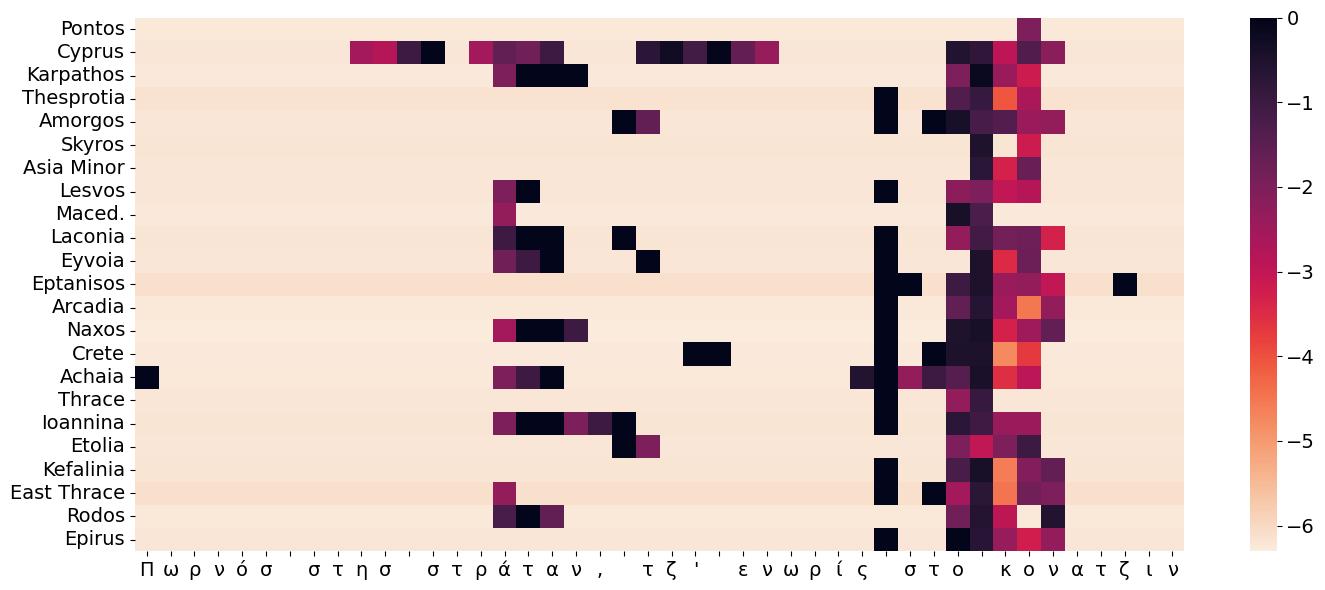

In [9]:
t = test[(test.area == "Κύπρος") & test.text.str.startswith('Πωρνό')].iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
plt.tick_params(axis='both', which='major', labelsize=14)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
ax.figure.tight_layout()
ax.figure.savefig("heatmap.pdf", format="PDF")

* Evaluating on unseen proverbs

In [10]:
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
gold = test.area.apply(lambda x: loc_name[x]).values
print(classification_report(gold, predictions, zero_division=0))

              precision    recall  f1-score   support

      Achaia       0.14      0.12      0.13        32
     Amorgos       0.19      0.14      0.16        22
     Arcadia       0.08      0.06      0.07        31
  Asia Minor       0.17      0.17      0.17        18
       Crete       0.23      0.23      0.23        30
      Cyprus       0.73      0.79      0.76        24
 East Thrace       0.12      0.17      0.14        24
      Epirus       0.11      0.13      0.12        23
   Eptanisos       0.25      0.35      0.29        23
      Etolia       0.40      0.33      0.36        24
      Eyvoia       0.07      0.15      0.10        20
    Ioannina       0.17      0.14      0.15        29
   Karpathos       0.37      0.25      0.30        28
   Kefalinia       0.11      0.15      0.13        27
     Laconia       0.04      0.04      0.04        27
      Lesvos       0.45      0.38      0.41        24
      Maced.       0.19      0.19      0.19        27
       Naxos       0.34    

* The confusion matrix can inform us about the confusion in the predictions

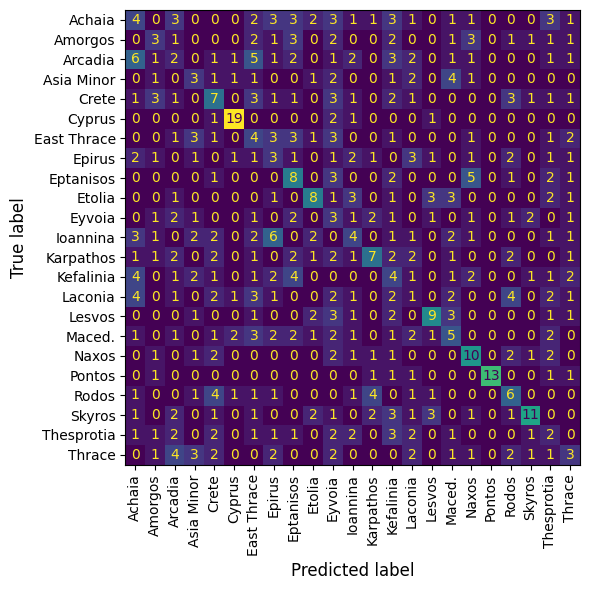

In [11]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.labelsize"] = 12
cm = ConfusionMatrixDisplay.from_predictions(gold, 
                                             predictions, xticks_rotation='vertical', colorbar=False)
cm.figure_.tight_layout()
cm.figure_.savefig('authorship_confusion.pdf', format="PDF")

## Benchmarking Standard Text Classifiers on Top of Character n-grams

In [12]:
vect = TfidfVectorizer(
    ngram_range=(2, 5), # token sequences
    analyzer="char", # tokens are characters
    max_df=0.5, # ignore tokens present in more than 50% of the texts
    min_df=2, # ignore tokens not present in at least two documents 
    lowercase=True
)
vect.fit(train.text.values)
print('Vocabulary:', len(vect.vocabulary_))
rep_t = vect.transform(['παροιμία'])
for i, feat in enumerate(rep_t.toarray()[0]):
    if feat>0:
        print(f'n-gram: "{vect.get_feature_names_out()[i]}"'
              f'\t(tfidf: {feat:.2f})')

Vocabulary: 81402
n-gram: "ία"	(tfidf: 0.21)
n-gram: "αρ"	(tfidf: 0.12)
n-gram: "αρο"	(tfidf: 0.21)
n-gram: "αροι"	(tfidf: 0.37)
n-gram: "ιμ"	(tfidf: 0.19)
n-gram: "ιμί"	(tfidf: 0.33)
n-gram: "ιμία"	(tfidf: 0.38)
n-gram: "μί"	(tfidf: 0.21)
n-gram: "μία"	(tfidf: 0.30)
n-gram: "οι"	(tfidf: 0.13)
n-gram: "οιμ"	(tfidf: 0.28)
n-gram: "πα"	(tfidf: 0.11)
n-gram: "παρ"	(tfidf: 0.18)
n-gram: "παρο"	(tfidf: 0.36)
n-gram: "ρο"	(tfidf: 0.12)
n-gram: "ροι"	(tfidf: 0.26)


### Logistic Regression

In [13]:
vect = TfidfVectorizer(ngram_range=(2, 5), 
                       analyzer="char",
                       max_df=0.5, 
                       min_df=2, lowercase=True)

regressor = LogisticRegression()

pipe = Pipeline([('vect', vect), ('ref', regressor)])

scores = cross_val_score(pipe,
                         train.text.values,
                         train.area.values,
                         cv=5,
                         n_jobs=-1)

cv_score = scores.mean()
print(cv_score)

pipe = Pipeline([('vect', vect), ('clf', LogisticRegression())])
pipe.fit(train.text, train.area)
preds = pipe.predict(test.text)
print(f'LogisticRegression\n{classification_report(test.area.values, preds)}')

0.2859903381642512
LogisticRegression
                 precision    recall  f1-score   support

        Ήπειρος       0.17      0.17      0.17        23
        Αιτωλία       0.38      0.58      0.46        24
        Αμοργός       0.13      0.18      0.15        22
Ανατολική Θράκη       0.16      0.21      0.18        24
        Αρκαδία       0.20      0.16      0.18        31
          Αχαΐα       0.39      0.22      0.28        32
      Επτάνησος       0.35      0.65      0.45        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.05      0.05      0.05        22
          Θράκη       0.25      0.16      0.20        25
       Ιωάννινα       0.29      0.21      0.24        29
       Κάρπαθος       0.40      0.29      0.33        28
     Κεφαλληνία       0.14      0.11      0.12        27
          Κρήτη       0.35      0.27      0.30        30
         Κύπρος       0.72      0.75      0.73        24
         Λέσβος       0.42      0.62      0.50   

### SVM

In [14]:
def objective(trial):

    C = trial.suggest_loguniform('C', 1e-10, 1e10)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    classifier = LinearSVC(C=C, penalty=penalty, dual=False, max_iter=5000)

    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             train.area,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-11-08 17:08:17,635] A new study created in memory with name: no-name-c199887a-8df3-486b-a161-821492d25a82
[I 2024-11-08 17:08:21,239] Trial 0 finished with value: 0.10724637681159419 and parameters: {'C': 2.4561624950125837e-07, 'penalty': 'l2'}. Best is trial 0 with value: 0.10724637681159419.
[I 2024-11-08 17:08:23,497] Trial 2 finished with value: 0.1511111111111111 and parameters: {'C': 0.1337822151655172, 'penalty': 'l1'}. Best is trial 2 with value: 0.1511111111111111.
[I 2024-11-08 17:08:25,689] Trial 4 finished with value: 0.30135265700483094 and parameters: {'C': 0.36566835893554567, 'penalty': 'l2'}. Best is trial 4 with value: 0.30135265700483094.
[I 2024-11-08 17:08:27,438] Trial 5 finished with value: 0.1714009661835749 and parameters: {'C': 2109637.4760006447, 'penalty': 'l1'}. Best is trial 4 with value: 0.30135265700483094.
[I 2024-11-08 17:08:28,382] Trial 7 finished with value: 0.043188405797101447 and parameters: {'C': 8.838124430184772e-08, 'penalty': 'l1'}.

In [15]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)
with open('best_params_svm_clf.json', 'w') as f:
    json.dump(best_params, f)

best value: 0.30144927536231886
best trial: FrozenTrial(number=9, state=1, values=[0.30144927536231886], datetime_start=datetime.datetime(2024, 11, 8, 17, 8, 17, 687636), datetime_complete=datetime.datetime(2024, 11, 8, 17, 8, 52, 592881), params={'C': 0.23554715300191015, 'penalty': 'l2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=10000000000.0, log=True, low=1e-10, step=None), 'penalty': CategoricalDistribution(choices=('l1', 'l2'))}, trial_id=9, value=None)
best params: {'C': 0.23554715300191015, 'penalty': 'l2'}


In [16]:
classifier = LinearSVC(**best_params,  dual=False, max_iter=5000)
predictor_clf = Pipeline([('vect', vect), ('clf', LinearSVC())]) 
predictor_clf.fit(train.text.values, train.area.values) 
predictions_clf = predictor_clf.predict(test.text.values) 
print(classification_report(test.area.values, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.09      0.09      0.09        23
        Αιτωλία       0.42      0.46      0.44        24
        Αμοργός       0.26      0.32      0.29        22
Ανατολική Θράκη       0.19      0.25      0.22        24
        Αρκαδία       0.11      0.10      0.10        31
          Αχαΐα       0.31      0.25      0.28        32
      Επτάνησος       0.47      0.70      0.56        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.26      0.20      0.23        25
       Ιωάννινα       0.26      0.17      0.21        29
       Κάρπαθος       0.42      0.39      0.41        28
     Κεφαλληνία       0.25      0.22      0.24        27
          Κρήτη       0.36      0.33      0.34        30
         Κύπρος       0.70      0.96      0.81        24
         Λέσβος       0.45      0.54      0.49        24
        Λακωνία       0.10    

### KNN

In [17]:
# For some reason, scikit-learn will not always
# encode 'Ήπειρος'. This is a workaround.
area_encoded = LabelEncoder().fit_transform(train.area)

def objective(trial):

    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors,
                                      weights=weights,
                                      p=p)

    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             area_encoded,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-11-08 17:28:45,821] A new study created in memory with name: no-name-5a6f9c35-df3c-4f6b-ae84-88753476dfe1
[I 2024-11-08 17:28:47,586] Trial 2 finished with value: 0.2034782608695652 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.2034782608695652.
[I 2024-11-08 17:28:51,803] Trial 1 finished with value: 0.043574879227053144 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.2034782608695652.
[I 2024-11-08 17:28:52,323] Trial 4 finished with value: 0.17333333333333334 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.2034782608695652.
[I 2024-11-08 17:28:52,508] Trial 3 finished with value: 0.04560386473429952 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.2034782608695652.
[I 2024-11-08 17:28:54,762] Trial 8 finished with value: 0.18608695652173912 and parameters: {'n_neighbors': 8, 'we

In [18]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)
with open('best_params_knn_clf.json', 'w') as f:
    f.write(json.dumps(best_params))

best value: 0.21594202898550724
best trial: FrozenTrial(number=67, state=1, values=[0.21594202898550724], datetime_start=datetime.datetime(2024, 11, 8, 17, 29, 27, 514132), datetime_complete=datetime.datetime(2024, 11, 8, 17, 29, 34, 529173), params={'n_neighbors': 48, 'weights': 'distance', 'p': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=50, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': CategoricalDistribution(choices=(1, 2))}, trial_id=67, value=None)
best params: {'n_neighbors': 48, 'weights': 'distance', 'p': 2}


In [19]:
classifier = KNeighborsClassifier(**best_params)
pipe = Pipeline([('vect', vect), ('clf', classifier)])
pipe.fit(train.text, train.area)
score = pipe.score(test.text, test.area)
score

0.24521739130434783

In [20]:
predictor_clf = Pipeline([('vect', vect), ('clf', classifier)])
predictor_clf.fit(train.text, train.area)
predictions_clf = predictor_clf.predict(test.text)
print(classification_report(test.area, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.05      0.04      0.05        23
        Αιτωλία       0.26      0.29      0.27        24
        Αμοργός       0.19      0.27      0.22        22
Ανατολική Θράκη       0.14      0.21      0.17        24
        Αρκαδία       0.14      0.13      0.13        31
          Αχαΐα       0.21      0.19      0.20        32
      Επτάνησος       0.28      0.57      0.38        23
         Εύβοια       0.06      0.05      0.05        20
      Θεσπρωτία       0.06      0.05      0.05        22
          Θράκη       0.27      0.16      0.20        25
       Ιωάννινα       0.13      0.07      0.09        29
       Κάρπαθος       0.38      0.21      0.27        28
     Κεφαλληνία       0.18      0.19      0.18        27
          Κρήτη       0.24      0.20      0.22        30
         Κύπρος       0.53      0.71      0.61        24
         Λέσβος       0.38      0.46      0.42        24
        Λακωνία       0.12    

### Random Forest

In [21]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    classifier = RandomForestClassifier(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(2, 5),
                           analyzer="char",
                           max_df=0.5,
                           min_df=2,
                           lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('clf', classifier)])
    scores = cross_val_score(pipe,
                             train.text,
                             train.area,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2024-11-08 17:30:11,322] A new study created in memory with name: no-name-16bf1d64-5962-41d6-a560-4a8f3ee4e0c0
[I 2024-11-08 17:30:14,490] Trial 2 finished with value: 0.20560386473429954 and parameters: {'n_estimators': 115, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.20560386473429954.
[I 2024-11-08 17:30:14,725] Trial 1 finished with value: 0.23352657004830918 and parameters: {'n_estimators': 171, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.23352657004830918.
[I 2024-11-08 17:30:15,653] Trial 0 finished with value: 0.2422222222222222 and parameters: {'n_estimators': 307, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.2422222222222222.
[I 2024-11-08 17:30:17,190] Trial 3 finished with value: 0.22434782608695653 and parameters: {'n_estimators': 159, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 0 with 

In [22]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)
with open('best_params_rf_clf.json', 'w') as f:
    json.dump(best_params, f)

best value: 0.2468599033816425
best trial: FrozenTrial(number=37, state=1, values=[0.2468599033816425], datetime_start=datetime.datetime(2024, 11, 8, 17, 30, 36, 742432), datetime_complete=datetime.datetime(2024, 11, 8, 17, 31, 1, 788352), params={'n_estimators': 325, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=37, value=None)
best params: {'n_estimators': 325, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1}


In [23]:
classifier = RandomForestClassifier(**best_params)
pipe = Pipeline([('vect', vect), ('clf', classifier)])
pipe.fit(train.text, train.area)
score = pipe.score(test.text, test.area)
score

0.2956521739130435

In [24]:
predictor_clf = Pipeline([('vect', vect), ('clf', classifier)])
predictor_clf.fit(train.text, train.area)
predictions_clf = predictor_clf.predict(test.text)
print(classification_report(test.area, predictions_clf))

                 precision    recall  f1-score   support

        Ήπειρος       0.07      0.04      0.05        23
        Αιτωλία       0.33      0.71      0.45        24
        Αμοργός       0.08      0.14      0.10        22
Ανατολική Θράκη       0.15      0.21      0.17        24
        Αρκαδία       0.18      0.16      0.17        31
          Αχαΐα       0.48      0.38      0.42        32
      Επτάνησος       0.24      0.22      0.23        23
         Εύβοια       0.00      0.00      0.00        20
      Θεσπρωτία       0.13      0.14      0.13        22
          Θράκη       0.43      0.24      0.31        25
       Ιωάννινα       0.10      0.07      0.08        29
       Κάρπαθος       0.58      0.25      0.35        28
     Κεφαλληνία       0.21      0.22      0.21        27
          Κρήτη       0.33      0.17      0.22        30
         Κύπρος       0.55      0.88      0.68        24
         Λέσβος       0.43      0.62      0.51        24
        Λακωνία       0.09    

## Predicting the Location of Proverbs Based on Words

* Focusing on ones which are shared in multiple locations

In [25]:
duplicates = pd.read_csv('data/duplicates_geolocated.csv')
duplicates['place'] = duplicates['place'].apply(ast.literal_eval)
duplicates['area'] = duplicates['area'].apply(ast.literal_eval)
duplicates

,text,place,place_num,area,area_num,latlon
0,(Ε)πήρε βάγια,"{Λακωνία, Ήπειρος}",2,"{Λακωνία, Ήπειρος}",2,"[(36.76027945, 22.79046431389755), (39.6501917..."
1,"Άβολος ο νους, διπλός ο κόπος","{Νίσυρος, Μικρά Ασία>Τσεσμές (Κρήνη)}",2,"{Νίσυρος, Μικρά Ασία}",2,"[(38.1846366, 23.5122768), (36.58904575, 27.16..."
2,Άβουλος νους διπλός κόπος,"{Θράκη>Αίνος, Θήρα (Σαντορίνη)}",2,"{Θράκη, Θήρα (Σαντορίνη)}",2,"[(36.4071112, 25.456663652707153), (38.0105134..."
3,"Άβουλος νους, διπλός ο κόπος","{Ρόδος, Κρήτη, Αμοργός}",3,"{Ρόδος, Κρήτη, Αμοργός}",3,"[(35.308495199999996, 24.46334231842296), (36...."
4,Άβουλος ο νους διπλός ο κόπος,"{Ήπειρος>Τσαμαντάς, Σάμος>Μαραθόκαμπος, Ρόδος,...",5,"{Σάμος, Ρόδος, Θράκη, Ήπειρος}",4,"[(36.172529749999995, 27.91940163839584), (37...."
...,...,...,...,...,...,...
3199,"ο παθός, μαθός","{Λέρος, Αργολίδα>Σχοινοχώρι}",2,"{Αργολίδα, Λέρος}",2,"[(37.9933789, 23.5389128), (37.56626615, 22.85..."
3200,πονάει το δόντι,"{Φωκίδα, Θεσσαλία>Τρίκαλα}",2,"{Φωκίδα, Θεσσαλία}",2,"[(39.5564697, 21.6905283), (38.5001712, 22.249..."
3201,"που Πάτρα, που Φλομίτσι!","{Μάνη>Αβία, Μεσσηνία>Αβία>Κάμπος}",2,"{Μάνη, Μεσσηνία}",2,"[(36.70694815, 22.122363134012744), (41.409747..."
3202,τού έδειξε τα δόντια,"{Εύβοια, Αρκαδία>Τεγέα}",2,"{Εύβοια, Αρκαδία}",2,"[(37.42908855, 22.423541964571157), (38.494172..."


In [26]:
# showing cases when only two candidate area exist and the model said one 
duplicates.insert(4, "prediction", predictor_clf.predict(duplicates.text))
duplicate_dilemma = duplicates.apply(lambda row: (row.area_num==2)&(row.prediction in row.area), 1)
duplicates[duplicate_dilemma].sort_values(by="place_num").head(5)

,text,place,place_num,area,prediction,area_num,latlon
6,Άγιασε ο μαχαιροβγάλτης και πουλεί σκουρολεπίδες,"{Ήπειρος, Κεφαλληνία}",2,"{Ήπειρος, Κεφαλληνία}",Κεφαλληνία,2,"[(38.2660322, 20.53739027630735), (39.6501917,..."
2201,Ο ζουρλός τον βουρλισμένον σαν τα μάτια του το...,"{Αχαΐα>Πάτρα, Αμοργός}",2,"{Αχαΐα, Αμοργός}",Αμοργός,2,"[(36.85252415, 25.898486967715655), (38.069274..."
2196,"Ο γυιός, γαμπρός δε γίνεται κι η νύφη θυγατέρα","{Μικρά Ασία>Σινώπη, Κρήτη>Λασίθι>Κάτω χωριό}",2,"{Κρήτη, Μικρά Ασία}",Κρήτη,2,"[(38.1846366, 23.5122768), (35.308495199999996..."
2190,"Ο γάιδαρος κουβαλεί κρασί, και πίνει νερό","{Επτάνησος, Κεφαλληνία}",2,"{Επτάνησος, Κεφαλληνία}",Επτάνησος,2,"[(38.2660322, 20.53739027630735), (38.8351105,..."
2171,Ο Μανώλης με τα λόγια κτίζ' ανώγεια και κατώγεια,"{Κρήτη>Σητεία>Χαμέζι, Ιωάννινα}",2,"{Κρήτη, Ιωάννινα}",Κρήτη,2,"[(35.308495199999996, 24.46334231842296), (39...."


* Showing the ones our classifier located on Cyrpus.

In [27]:
is_it_cyprus = duplicates.apply(lambda row: (row.prediction=='Κύπρος')&(row.prediction in row.area), 1)
duplicates[is_it_cyprus]

,text,place,place_num,area,prediction,area_num,latlon
137,"Άρον, άρον","{Κύπρος, Ήπειρος}",2,"{Κύπρος, Ήπειρος}",Κύπρος,2,"[(34.9174159, 32.889902651331866), (39.6501917..."
525,"Όπου δεμ πέφτει λόγος, πέφτει ράβδος","{Νίσυρος, Κύπρος}",2,"{Νίσυρος, Κύπρος}",Κύπρος,2,"[(34.9174159, 32.889902651331866), (36.5890457..."


## Regression on the Coordinates Using Words

* Instead of classifying, predicting the geographical coordinates.

In [28]:
optimization_results = []

### Linear Regression

* Linear regression provides feature importance, i.e., terms that distinguish spatially, from South to North, from West to East.

In [29]:
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                       min_df=10, lowercase=True)

regressor = LinearRegression()

pipe = Pipeline([('vect', vect), ('ref', regressor)])

scores = cross_val_score(pipe, 
                         train.text.values, 
                         train[["lat", "lon"]].values,
                         cv=5,
                         n_jobs=-1)

cv_score = scores.mean()
cv_score

np.float64(0.11066165692751387)

In [30]:
linear_regression_pipe = Pipeline([('vect', vect), ('reg', regressor)])
linear_regression_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = linear_regression_pipe.score(
    test.text.values, test[["lat", "lon"]].values)
score

0.17142981802136242

In [31]:
predicted_coords = linear_regression_pipe.predict(test.text.values)

mae_lat, mae_lon = (
    mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'LinearRegression', 
    cv_score, 
    score,
    None,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.3804352445879466 2.804612334145914
3.003499727635002 14.697230993565796


### ElasticNet

In [32]:
def objective(trial):

    alpha = trial.suggest_loguniform('alpha', 1e-4, 1.0)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    regressor = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    vect = TfidfVectorizer(ngram_range=(2,5), 
                        analyzer="char", 
                        max_df=0.5,
                        min_df=10, 
                        lowercase=True)

    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-08 17:32:34,097] A new study created in memory with name: no-name-5e3e6126-32ec-48cc-8ba7-a93f2c46139e
[I 2024-11-08 17:32:36,908] Trial 0 finished with value: 0.06860635349054618 and parameters: {'alpha': 0.0039364699148396265, 'l1_ratio': 0.9105429414131407}. Best is trial 0 with value: 0.06860635349054618.
[I 2024-11-08 17:32:44,830] Trial 1 finished with value: 0.19879391257163476 and parameters: {'alpha': 0.0008581859035821538, 'l1_ratio': 0.9411724382611175}. Best is trial 1 with value: 0.19879391257163476.
[I 2024-11-08 17:32:45,588] Trial 2 finished with value: -0.0003549715765302164 and parameters: {'alpha': 0.05040506346078732, 'l1_ratio': 0.9300132130656015}. Best is trial 1 with value: 0.19879391257163476.
[I 2024-11-08 17:32:57,603] Trial 3 finished with value: 0.2647559673661214 and parameters: {'alpha': 0.00026736184157491217, 'l1_ratio': 0.15308853714683524}. Best is trial 3 with value: 0.2647559673661214.
[I 2024-11-08 17:32:58,369] Trial 4 finished with val

In [33]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)
with open('best_params_el_reg.json', 'w') as f:
    json.dump(best_params, f)

best value: 0.26891665072515514
best trial: FrozenTrial(number=81, state=1, values=[0.26891665072515514], datetime_start=datetime.datetime(2024, 11, 8, 17, 47, 38, 480300), datetime_complete=datetime.datetime(2024, 11, 8, 17, 47, 54, 664512), params={'alpha': 0.00018980536445682223, 'l1_ratio': 0.33703109506665707}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=1.0, log=True, low=0.0001, step=None), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=81, value=None)
best params: {'alpha': 0.00018980536445682223, 'l1_ratio': 0.33703109506665707}


In [34]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_l1_ratio,state
0,0,0.068606,2024-11-08 17:32:34.098390,2024-11-08 17:32:36.908770,0 days 00:00:02.810380,0.003936,0.910543,COMPLETE
1,1,0.198794,2024-11-08 17:32:36.909215,2024-11-08 17:32:44.830016,0 days 00:00:07.920801,0.000858,0.941172,COMPLETE
2,2,-0.000355,2024-11-08 17:32:44.830521,2024-11-08 17:32:45.588437,0 days 00:00:00.757916,0.050405,0.930013,COMPLETE
3,3,0.264756,2024-11-08 17:32:45.588867,2024-11-08 17:32:57.603659,0 days 00:00:12.014792,0.000267,0.153089,COMPLETE
4,4,-0.000355,2024-11-08 17:32:57.604092,2024-11-08 17:32:58.369638,0 days 00:00:00.765546,0.095666,0.743050,COMPLETE
...,...,...,...,...,...,...,...,...
95,95,0.264878,2024-11-08 17:51:12.095674,2024-11-08 17:51:35.542912,0 days 00:00:23.447238,0.000135,0.450885,COMPLETE
96,96,0.255767,2024-11-08 17:51:35.543822,2024-11-08 17:51:44.225770,0 days 00:00:08.681948,0.000353,0.400313,COMPLETE
97,97,0.262704,2024-11-08 17:51:44.226221,2024-11-08 17:51:55.249721,0 days 00:00:11.023500,0.000293,0.329509,COMPLETE
98,98,0.014531,2024-11-08 17:51:55.250188,2024-11-08 17:51:56.715848,0 days 00:00:01.465660,0.010330,0.357810,COMPLETE


In [35]:
trials_df['value'].describe()

count    100.000000
mean       0.208547
std        0.092921
min       -0.000355
25%        0.198327
50%        0.257604
75%        0.267220
max        0.268917
Name: value, dtype: float64

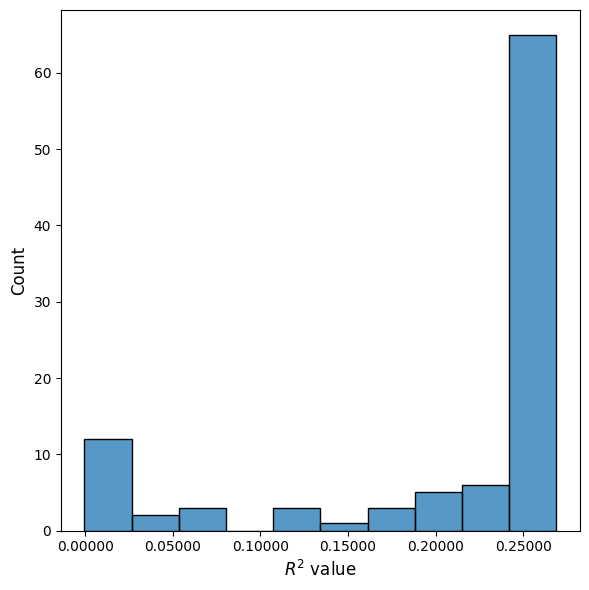

In [36]:
ax = sns.histplot(trials_df['value'])
ticks = ax.get_xticks()
ax.set_xticklabels(['{:.5f}'.format(t) for t in ticks])
ax.set_xlabel(r'$R^2$ value')
plt.tight_layout()

In [37]:
from plotly.io import show

fig = optuna.visualization.plot_optimization_history(study)
show(fig)

In [38]:
fig = optuna.visualization.plot_contour(study, params=["alpha", "l1_ratio"])
show(fig)

In [39]:
fig = optuna.visualization.plot_slice(study, params=["alpha", "l1_ratio"])
show(fig)

In [40]:
fig = optuna.visualization.plot_parallel_coordinate(
    study, params=["alpha", "l1_ratio"])
show(fig)

In [41]:
fig = optuna.visualization.plot_param_importances(study)
show(fig)

In [42]:
regressor = ElasticNet(**best_params)
elastic_net_pipe = Pipeline([('vect', vect), ('reg', regressor)])
elastic_net_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = elastic_net_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.19116439371486993

In [43]:
predicted_coords = elastic_net_pipe.predict(test.text.values)

mae_lat, mae_lon = (
    mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'ElasticNet', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.3688409487818975 2.774948746874235
2.93916632011071 14.309131929393581


### KNN

In [44]:
def objective(trial):

    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])
    regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                    weights=weights, 
                                    p=p)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-08 17:52:12,635] A new study created in memory with name: no-name-62637ece-43c2-4ce2-9859-fa492234b283
[I 2024-11-08 17:52:13,433] Trial 0 finished with value: -0.011982803629540639 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: -0.011982803629540639.
[I 2024-11-08 17:52:13,923] Trial 1 finished with value: -0.0034767114552497593 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: -0.0034767114552497593.
[I 2024-11-08 17:52:14,234] Trial 2 finished with value: 0.04581842571964936 and parameters: {'n_neighbors': 40, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.04581842571964936.
[I 2024-11-08 17:52:14,672] Trial 3 finished with value: 0.006755503409824726 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'p': 2}. Best is trial 2 with value: 0.04581842571964936.
[I 2024-11-08 17:52:15,407] Trial 4 finished with value: 0.04581842571964936 and parameters: {'n_neig

In [45]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)
with open('best_params_knn_reg.json', 'w') as f:
    json.dump(best_params, f)

best value: 0.05683979552510965
best trial: FrozenTrial(number=31, state=1, values=[0.05683979552510965], datetime_start=datetime.datetime(2024, 11, 8, 17, 52, 26, 149309), datetime_complete=datetime.datetime(2024, 11, 8, 17, 52, 26, 379052), params={'n_neighbors': 20, 'weights': 'uniform', 'p': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=50, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': CategoricalDistribution(choices=(1, 2))}, trial_id=31, value=None)
best params: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}


In [46]:
regressor = KNeighborsRegressor(**best_params)
knr_pipe = Pipeline([('vect', vect), ('reg', regressor)])
knr_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = knr_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.07013869024375446

In [47]:
predicted_coords = knr_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'KNeighborsRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.4724193533739125 3.1334937826661555
3.341906123689139 16.64588229495783


### Random Forest

In [68]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    regressor = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-08 18:12:54,129] A new study created in memory with name: no-name-a26b5422-80a5-418a-a145-25c0d03de54c
[I 2024-11-08 18:12:55,658] Trial 0 finished with value: 0.10541910120786854 and parameters: {'n_estimators': 131, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.10541910120786854.
[I 2024-11-08 18:12:57,315] Trial 1 finished with value: 0.10476001623730666 and parameters: {'n_estimators': 140, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.10541910120786854.
[I 2024-11-08 18:13:00,714] Trial 2 finished with value: 0.10045552170032694 and parameters: {'n_estimators': 459, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.10541910120786854.
[I 2024-11-08 18:13:06,928] Trial 3 finished with value: 0.1057510221738606 and parameters: {'n_estimators': 494, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 3 with

In [69]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)
with open('best_params_rf_reg.json', 'w') as f:
    json.dump(best_params, f)

best value: 0.10711369091793702
best trial: FrozenTrial(number=62, state=1, values=[0.10711369091793702], datetime_start=datetime.datetime(2024, 11, 8, 18, 15, 51, 817114), datetime_complete=datetime.datetime(2024, 11, 8, 18, 15, 55, 538265), params={'n_estimators': 301, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=62, value=None)
best params: {'n_estimators': 301, 'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 5}


In [70]:
regressor = RandomForestRegressor(**best_params)
random_forest_pipe = Pipeline([('vect', vect), ('reg', regressor)])
random_forest_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = random_forest_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.1475265063699165

In [51]:
predicted_coords = random_forest_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2)

optimization_results.append([
    'RandomForestRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.428377082898693 2.8181271244442487
3.15541998765026 14.625194669553784


### Extremely Randomized Trees

In [52]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    regressor = ExtraTreesRegressor(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    n_jobs=-1)
    
    vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, 
                           min_df=10, lowercase=True)
    
    pipe = Pipeline([('vect', vect), ('ref', regressor)])
    scores = cross_val_score(pipe, 
                             train.text.values, 
                             train[["lat", "lon"]].values,
                             cv=5,
                             n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-11-08 18:00:00,894] A new study created in memory with name: no-name-fbede237-5d86-4225-962c-2a3b2de80547
[I 2024-11-08 18:00:01,854] Trial 0 finished with value: 0.1026371848345935 and parameters: {'n_estimators': 291, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.1026371848345935.
[I 2024-11-08 18:00:02,612] Trial 1 finished with value: 0.09850940816342696 and parameters: {'n_estimators': 223, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.1026371848345935.
[I 2024-11-08 18:00:03,242] Trial 2 finished with value: 0.09451797921973534 and parameters: {'n_estimators': 297, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.1026371848345935.
[I 2024-11-08 18:00:04,541] Trial 3 finished with value: 0.10073565671889236 and parameters: {'n_estimators': 425, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with v

In [ ]:
print('best value:', study.best_value)
print('best trial:', study.best_trial)
best_params = study.best_trial.params
print('best params:', best_params)
with open('best_params_xt_reg.json', 'w') as f:
    json.dump(best_params, f)

best value: 0.10613796706180176
best trial: FrozenTrial(number=7, state=1, values=[0.10613796706180176], datetime_start=datetime.datetime(2024, 11, 8, 18, 0, 6, 904665), datetime_complete=datetime.datetime(2024, 11, 8, 18, 0, 8, 837580), params={'n_estimators': 414, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=7, value=None)
best params: {'n_estimators': 414, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 10}


In [54]:
regressor = ExtraTreesRegressor(**best_params)
extra_trees_pipe = Pipeline([('vect', vect), ('reg', regressor)])
extra_trees_pipe.fit(train.text.values, train[["lat", "lon"]].values)
score = extra_trees_pipe.score(test.text.values, test[["lat", "lon"]].values)
score

0.15138866212443225

In [55]:
predicted_coords = extra_trees_pipe.predict(test.text.values)

mae_lat, mae_lon = (mean_absolute_error(test.lat.values, predicted_coords[:, 0]),
                    mean_absolute_error(test.lon.values, predicted_coords[:, 1]))
mse_lat, mse_lon = (
    root_mean_squared_error(test.lat.values, predicted_coords[:, 0])**2,
    root_mean_squared_error(test.lon.values, predicted_coords[:, 1])**2
)

optimization_results.append([
    'ExtraTreesRegressor', 
    study.best_value, 
    score,
    best_params,
    mae_lat, 
    mae_lon,
    mse_lat,
    mse_lon
])

print(mae_lat, mae_lon)
print(mse_lat, mse_lon)

1.4324469409732572 2.8449869876581024
3.1474397108528946 14.676150289660574


In [56]:
columns = [
    'regressor',
    'cv_score',
    'test_score',
    'best_params',
    'mae_lat', 
    'mae_lon',
    'mse_lat',
    'mse_lon'
]

optimization_results_df = pd.DataFrame(optimization_results, columns=columns)
optimization_results_df

,regressor,cv_score,test_score,best_params,mae_lat,mae_lon,mse_lat,mse_lon
0,LinearRegression,0.110662,0.171430,None,1.380435,2.804612,3.003500,14.697231
1,ElasticNet,0.268917,0.191164,"{'alpha': 0.00018980536445682223, 'l1_ratio': ...",1.368841,2.774949,2.939166,14.309132
2,KNeighborsRegressor,0.056840,0.070139,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 2}",1.472419,3.133494,3.341906,16.645882
3,RandomForestRegressor,0.107070,0.151627,"{'n_estimators': 453, 'max_depth': 32, 'min_sa...",1.428377,2.818127,3.155420,14.625195
4,ExtraTreesRegressor,0.106138,0.151389,"{'n_estimators': 414, 'max_depth': 32, 'min_sa...",1.432447,2.844987,3.147440,14.676150


In [57]:
optimization_results_df['mae_avg'] = optimization_results_df[
    ['mae_lat', 'mae_lon']].mean(axis=1)
optimization_results_df['mse_avg'] = optimization_results_df[
    ['mse_lat', 'mse_lon']].mean(axis=1)
optimization_results_df

,regressor,cv_score,test_score,best_params,mae_lat,mae_lon,mse_lat,mse_lon,mae_avg,mse_avg
0,LinearRegression,0.110662,0.171430,None,1.380435,2.804612,3.003500,14.697231,2.092524,8.850365
1,ElasticNet,0.268917,0.191164,"{'alpha': 0.00018980536445682223, 'l1_ratio': ...",1.368841,2.774949,2.939166,14.309132,2.071895,8.624149
2,KNeighborsRegressor,0.056840,0.070139,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 2}",1.472419,3.133494,3.341906,16.645882,2.302957,9.993894
3,RandomForestRegressor,0.107070,0.151627,"{'n_estimators': 453, 'max_depth': 32, 'min_sa...",1.428377,2.818127,3.155420,14.625195,2.123252,8.890307
4,ExtraTreesRegressor,0.106138,0.151389,"{'n_estimators': 414, 'max_depth': 32, 'min_sa...",1.432447,2.844987,3.147440,14.676150,2.138717,8.911795


In [58]:
optimization_results_df.round({
    'mae_lat':2, 
    'mae_lon': 2, 
    'mse_lat': 2, 
    'mse_lon': 2,
    'mae_avg': 2,
    'mse_avg': 2
})

,regressor,cv_score,test_score,best_params,mae_lat,mae_lon,mse_lat,mse_lon,mae_avg,mse_avg
0,LinearRegression,0.110662,0.171430,None,1.38,2.80,3.00,14.70,2.09,8.85
1,ElasticNet,0.268917,0.191164,"{'alpha': 0.00018980536445682223, 'l1_ratio': ...",1.37,2.77,2.94,14.31,2.07,8.62
2,KNeighborsRegressor,0.056840,0.070139,"{'n_neighbors': 20, 'weights': 'uniform', 'p': 2}",1.47,3.13,3.34,16.65,2.30,9.99
3,RandomForestRegressor,0.107070,0.151627,"{'n_estimators': 453, 'max_depth': 32, 'min_sa...",1.43,2.82,3.16,14.63,2.12,8.89
4,ExtraTreesRegressor,0.106138,0.151389,"{'n_estimators': 414, 'max_depth': 32, 'min_sa...",1.43,2.84,3.15,14.68,2.14,8.91


* Having arrived at this point, it is worth pointing out that the $\alpha$ parameter of `ElasticNet` is very small:

In [59]:
optimization_results_df[optimization_results_df.regressor == 'ElasticNet']['best_params']

1    {'alpha': 0.00018980536445682223, 'l1_ratio': ...
Name: best_params, dtype: object

* That means that in practice `ElasticNet` behaves pretty much like Ordinary Least Squares regression.

## Finding terms pushing North, South, West, and East

In [60]:
importance_pd = pd.DataFrame({
    "feature": elastic_net_pipe["vect"].get_feature_names_out(), 
    "lat": elastic_net_pipe["reg"].coef_[0, :],
    "lon": elastic_net_pipe["reg"].coef_[1, :]
})

### Words pushing $\uparrow$ North: higher lat

In [61]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
692,τρώγει,2.768507,-0.264348
552,πε,2.511027,-0.530863
96,ατ,2.475285,12.453856
631,σον,2.419648,11.856487
195,διάβολο,2.288155,-0.543043


### Words pushing $\downarrow$ South: lower lat

In [62]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
660,τζ,-4.528795,8.642149
662,τζαι,-4.216173,8.136146
661,τζαί,-4.187040,8.007570
664,τζι,-3.677877,7.408884
226,εγιώ,-3.017159,2.256124


### Words pushing $\rightarrow$ East: higher lon

In [63]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
96,ατ,2.475285,12.453856
630,σο,2.120248,12.060512
631,σον,2.419648,11.856487
616,ση,2.098464,10.820740
386,λύκον,1.207732,9.555793


### Words pushing $\leftarrow$ West: higher lon

In [64]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
157,γελάει,-0.095669,-4.752077
501,ου,0.674483,-4.664591
466,ναν,0.370216,-4.600812
107,αφέντη,0.125137,-4.096399
125,βλάχος,0.134093,-4.015270
